<a href="https://colab.research.google.com/github/ldselvera/data_drift/blob/main/data_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Drift Detection

In [8]:
import numpy as np
import pandas as pd

from scipy import stats

In [3]:
df=pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
df_numerical=df.iloc[:,[3,4,5,9]]
df_numerical.head()

,Age,Tenure,Balance,EstimatedSalary
0,42,2,0.00,101348.88
1,41,1,83807.86,112542.58
2,42,8,159660.80,113931.57
3,39,1,0.00,93826.63
4,43,2,125510.82,79084.10


In [7]:
df_salary_low=df_numerical[df_numerical['EstimatedSalary']<=10000] 
df_salary_high=df_numerical[df_numerical['EstimatedSalary']>10000]

## Kolmogorov-Smirnov (K-S) test

The K-S test is a nonparametric test that compares the cumulative distributions of two data sets. The null hypothesis for this test states that the data distributions from both the datasets are the same. If the null is rejected then we can conclude that there is a drift in the model.

In our analysis, we have only considered numerical columns for the test.

For generating our final Data Drift analysis, the chi-squared test can be applied for the categorical features to identify data drift.

In [9]:
p_value = 0.05

rejected = 0

for col in df_numerical.columns:
  test = stats.ks_2samp(df_salary_low[col], df_salary_high[col])

  if test[1] < p_value:
    rejected += 1
    print("Column rejected", col)

print("We rejected",rejected,"columns in total")

Column rejected Tenure
Column rejected EstimatedSalary
We rejected 2 columns in total


The K-S test has rejected the Tenure and Estimated Salary columns which means that the statistical properties of these two columns for both the datasets are not identical.

## Population Stability Index

It compares the distribution of the target variable in the test dataset to a training data set that was used to develop the model.

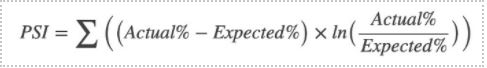

1. Divide the expected (test) dataset and the actual (training dataset) into buckets and define the boundary values of the buckets based on the minimum and maximum values of that column in train data.

2. Calculate the % of observations in each bucket for both expected and actual datasets.

3. Calculate the PSI as given in the formula

* PSI<=1
: This means there is no change or shift in the distributions of both datasets.

* 0.1< PSI<0.2
: This indicates a slight change or shift has occurred.

* PSI>0.2
: This indicates a large shift in the distribution has occurred between both datasets.

In [14]:
def scale_range (input, min, max):
  input += -(np.min(input))
  input /= np.max(input) / (max - min)
  input += min

  return input    

def sub_psi(e_perc, a_perc):
  if a_perc == 0:
      a_perc = 0.0001
  if e_perc == 0:
      e_perc = 0.0001
      
  value = (e_perc - a_perc) * np.log(e_perc / a_perc)
  
  return(value)

def psi(expected_array, actual_array, buckets):
  breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
  breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
  expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
  actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

  return(psi_value)  

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
  if len(expected.shape) == 1:
      psi_values = np.empty(len(expected.shape))
  else:
      psi_values = np.empty(expected.shape[axis])       

  for i in range(0, len(psi_values)):
        psi_values = psi(expected, actual, buckets)
    
  return(psi_values)

In [17]:
## Calculate psi for features
top_feature_list=df_salary_high.columns

for feature in top_feature_list:
  psi_t = calculate_psi(df_salary_high[feature], df_salary_low[feature])    
  print('Stability index for column ',feature,'is',psi_t)

Stability index for column  Age is 0.03165502336203871
Stability index for column  Tenure is 0.020563301225388273
Stability index for column  Balance is 0.017962803253901614
Stability index for column  EstimatedSalary is 6.901206246148547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
